In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import neo
from pathlib import Path

In [2]:
data_dir = Path(r'R:\home\firefly_link\468_patch_clamp')
files = Path(data_dir).glob("./**/*.smr")
smr_names = [str(f) for f in files]
dates = []
slips = []
cells = []
trial_string = []
df = pd.DataFrame()
df['SMR_file'] = smr_names

for data in df.itertuples():
    s = data.SMR_file

    par = Path(s).parts

    dates.append(int(par[par.index("468_patch_clamp") + 1][-8:]))
    
    slips.append(s[s.find("slip") + len("slip") : s.find("slip") + len("slip") + 1])

    cells.append(s[s.find("cell") + len("cell") : s.find("cell") + len("cell") + 1])
   
    trial_string.append("_".join(Path(s).parts[Path(s).parts.index("468_patch_clamp") : -1]))
df["date"] = dates
df["slip"] = slips
df["cell"] = cells
df["trial_string"] = trial_string
df = df[df['date']>20240123]
expt = []
for data in df.itertuples():
    s=data.SMR_file
    if '4ap' in s.lower():
        expt.append('4ap_40uM')
    elif 'control' in s.lower():
        expt.append('control')
    else:
        expt.append('none')
df['expt'] = expt
df

,SMR_file,date,slip,cell,trial_string,expt
80,R:\home\firefly_link\468_patch_clamp\20240131\...,20240131,1,1,468_patch_clamp_20240131_slip1_cell1,none
81,R:\home\firefly_link\468_patch_clamp\20240131\...,20240131,2,1,468_patch_clamp_20240131_slip2_cell1,none
82,R:\home\firefly_link\468_patch_clamp\20240131\...,20240131,3,1,468_patch_clamp_20240131_slip3_cell1,none
83,R:\home\firefly_link\468_patch_clamp\20240131\...,20240131,4,1,468_patch_clamp_20240131_slip4_cell1,none
84,R:\home\firefly_link\468_patch_clamp\20240131\...,20240131,5,1,468_patch_clamp_20240131_slip5_cell1,none


In [4]:
save_dir = Path(r'R:\home\firefly_link\468_patch_clamp\results_profiles')
index = 82
reader = neo.io.Spike2IO(filename=df.SMR_file[index],try_signal_grouping=False)
# read the block
bl = reader.read(lazy=False)[0]
#bl

In [5]:
asig_t = bl.segments[0].analogsignals[0]
# Extract sample times
#times = asig_t.times.rescale('s').magnitude
# Determine channel name, without leading b' 
asig = asig_t
ch = asig.name
V_cc = {}
I_cc = {}
V_vc = {}
I_vc = {}
# Extract sampling frequency
fs = float(asig.sampling_rate)
# Assign sampling times, sampling frequency and data to correct dictionary
for asig in bl.segments[0].analogsignals:
    ch = asig.name
    times = asig.times.rescale('s').magnitude
    if ch == 'V_cc':
        
        V_cc['times'] = times
        V_cc['signal'] = np.array(asig)
        #V_cc['fs'] = fs
    elif ch == 'I_cc':
        
        I_cc['times'] = times
        I_cc['signal'] = np.array(asig)
        #I_cc['fs'] = fs
        
    elif ch == 'I_vc':
        
        I_vc['times'] = times
        I_vc['signal'] = np.array(asig)
    
    elif ch == 'V_vc':
        
        V_vc['times'] = times
        V_vc['signal'] = np.array(asig)
        
V = np.squeeze(V_vc['signal'])
I = np.squeeze(I_vc['signal'])

In [6]:
def plot_scalebar(ax,x_pos,y_pos,x_len,y_len,thickness = 3,color = 'b'):
    ax.plot([x_pos,x_pos],[y_pos,y_pos+y_len],linewidth = thickness,color = color)
    ax.plot([x_pos,x_pos+x_len],[y_pos,y_pos],linewidth = thickness,color = color)
    

import os
data_dir = Path(save_dir,'_'.join(df.trial_string[index].split('_')[-3:]) )
os.mkdir(data_dir)
data_dir

WindowsPath('R:/home/firefly_link/468_patch_clamp/results_profiles/20240131_slip3_cell1')

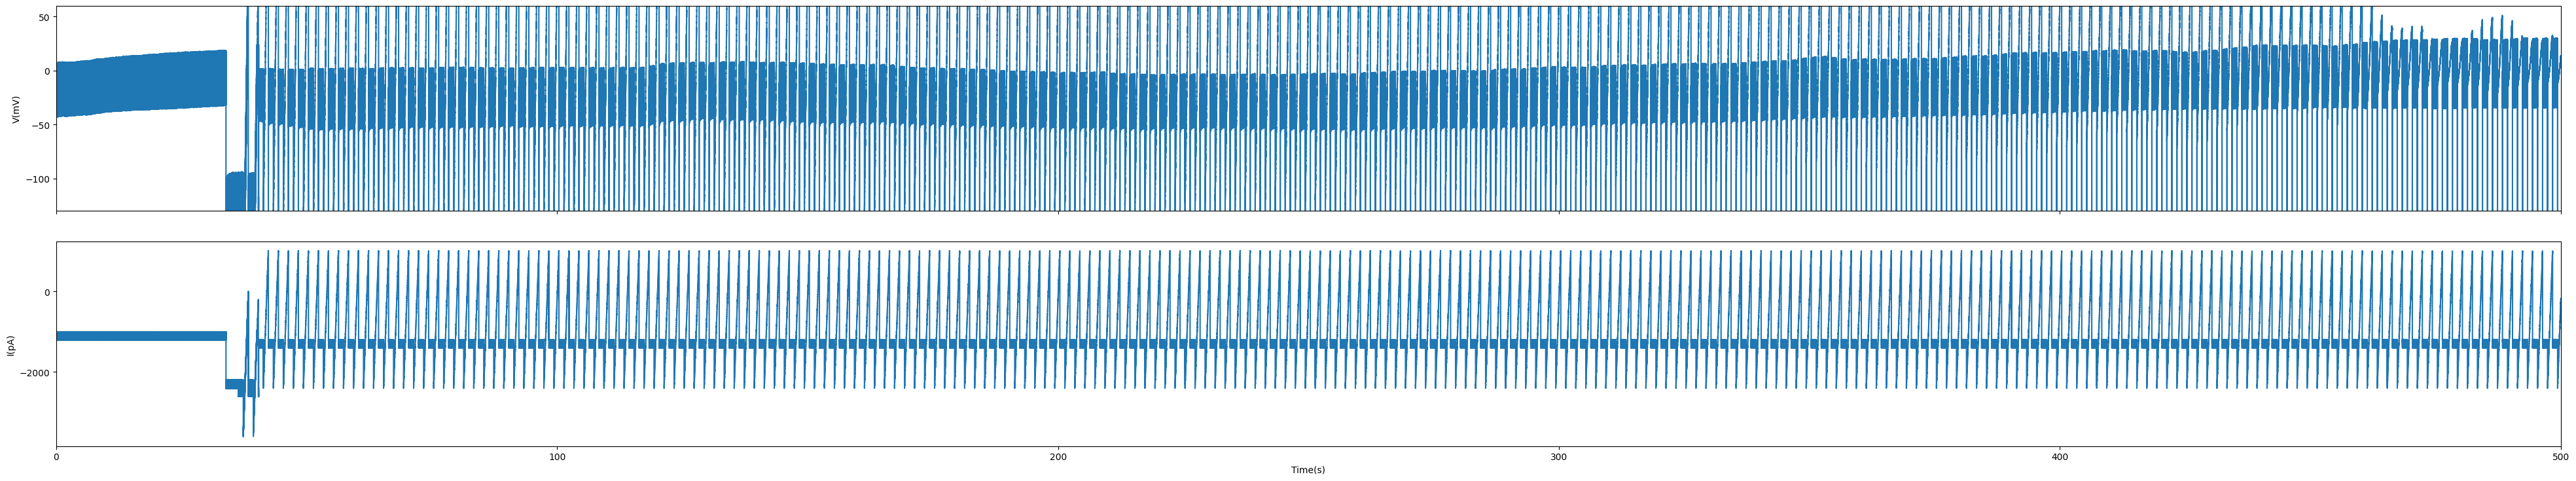

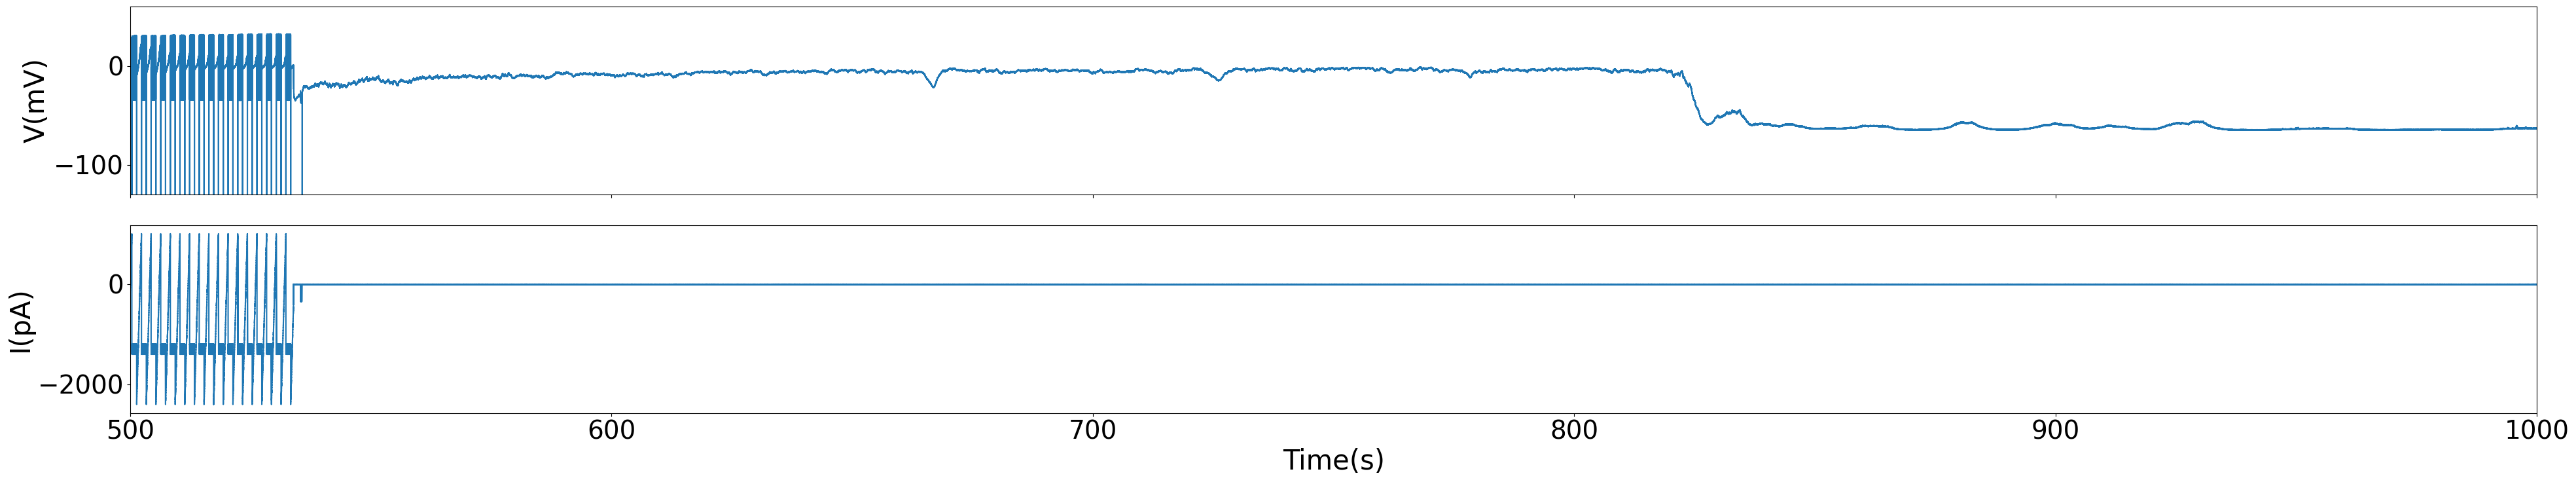

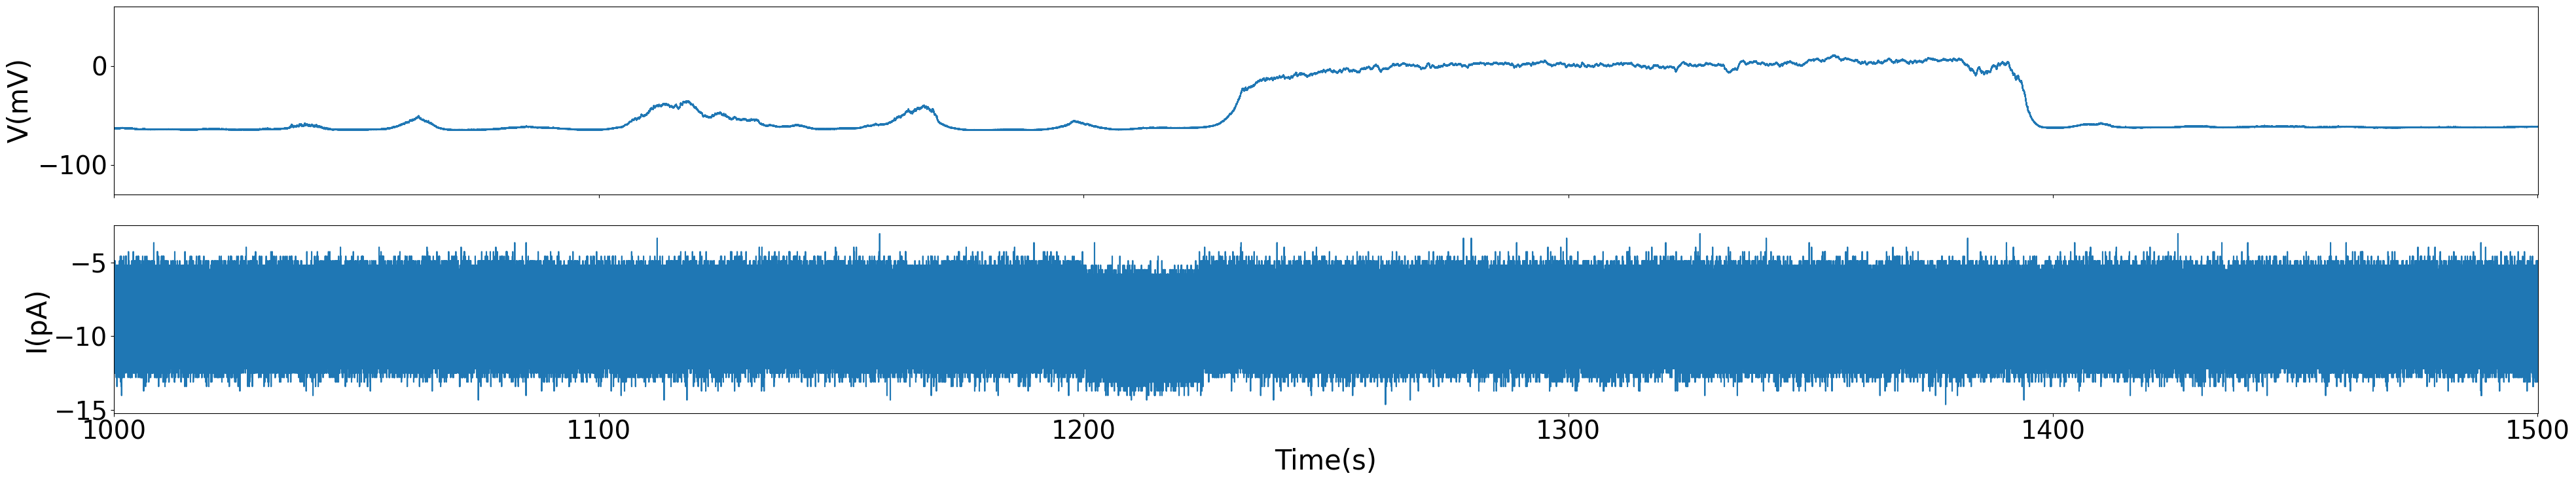

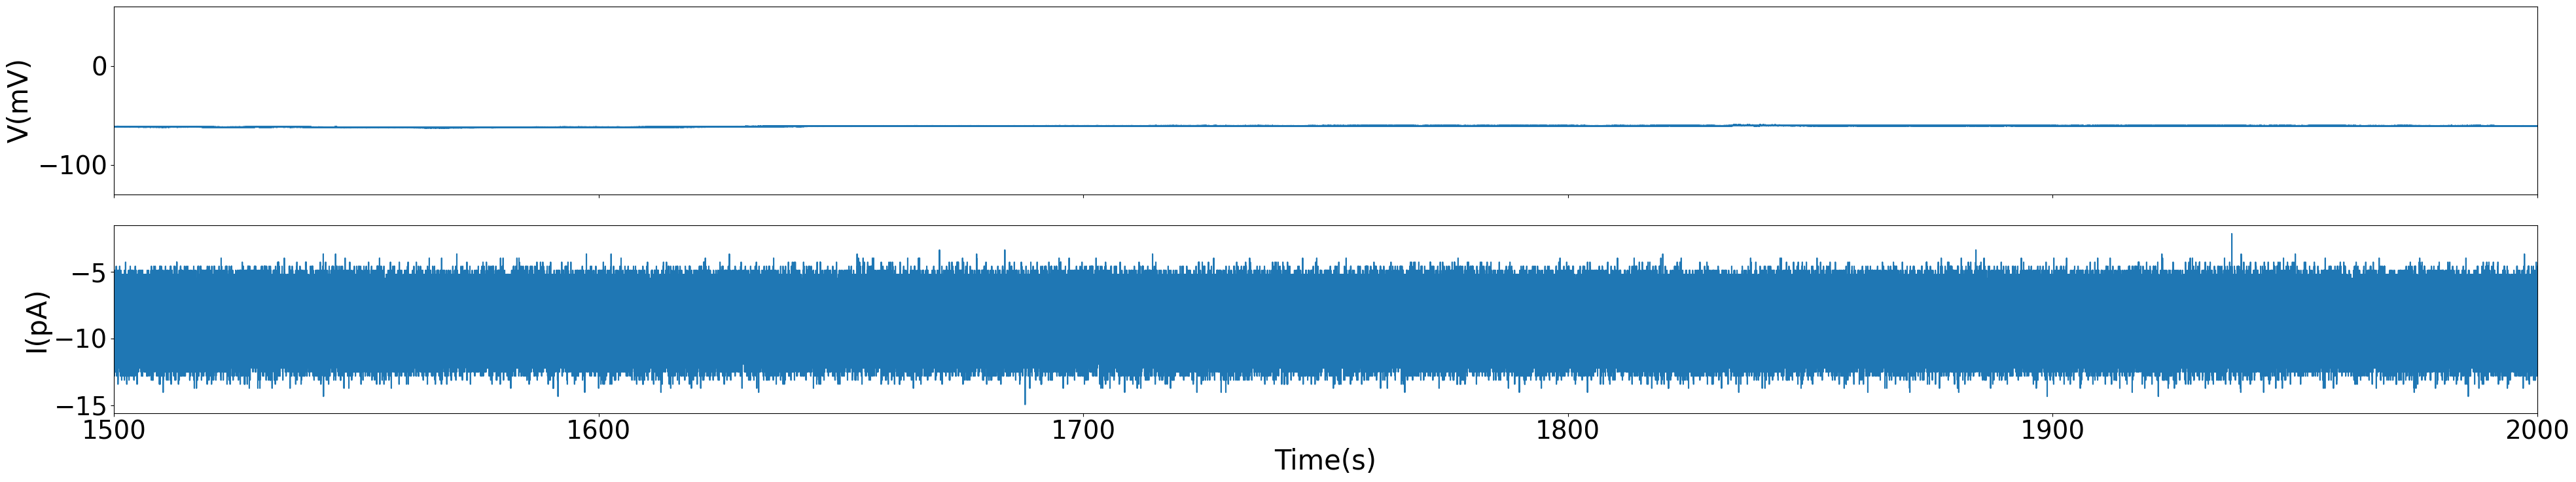

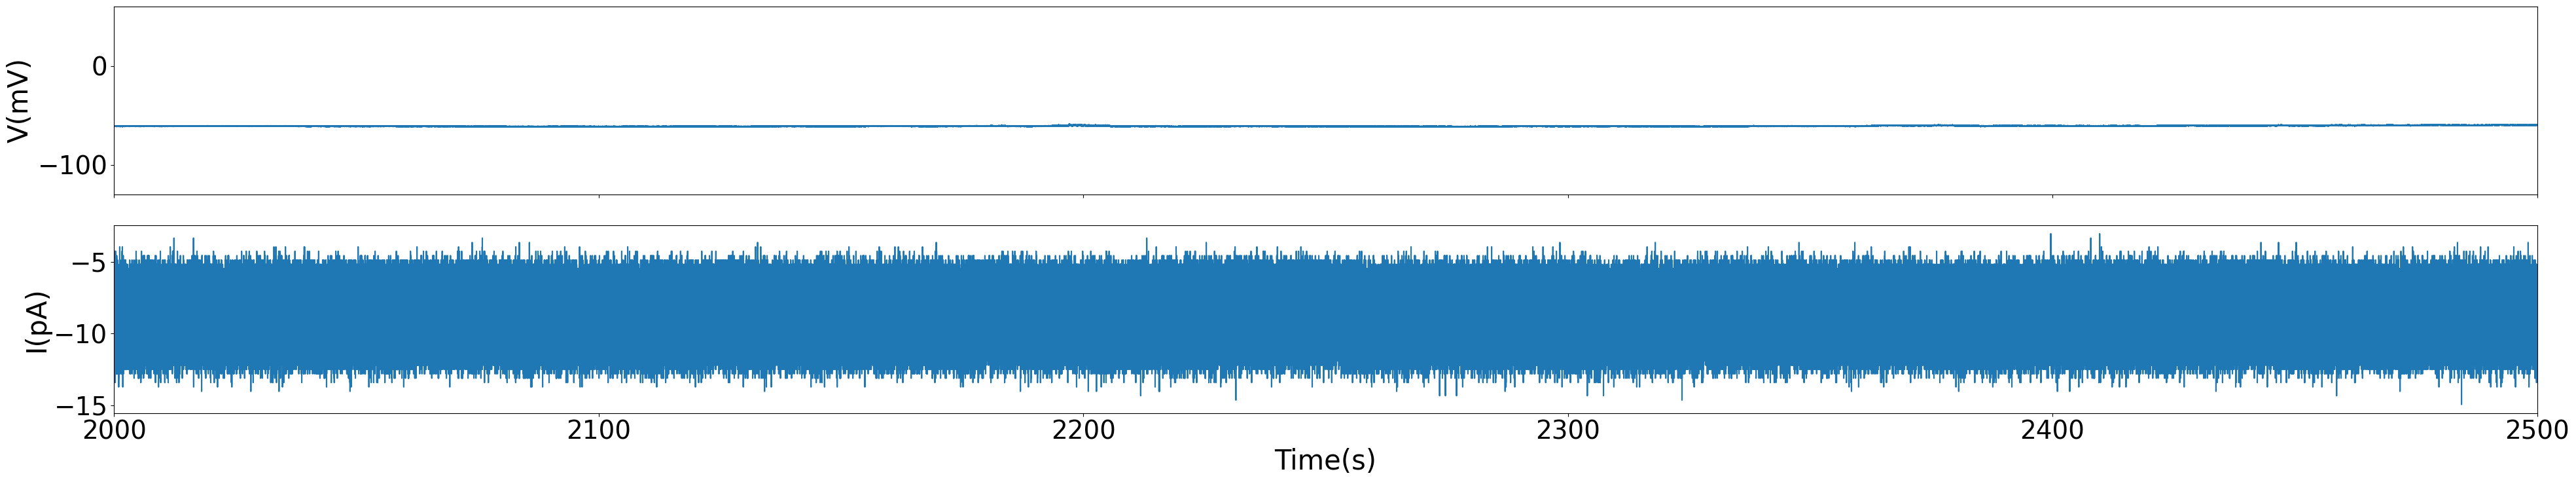

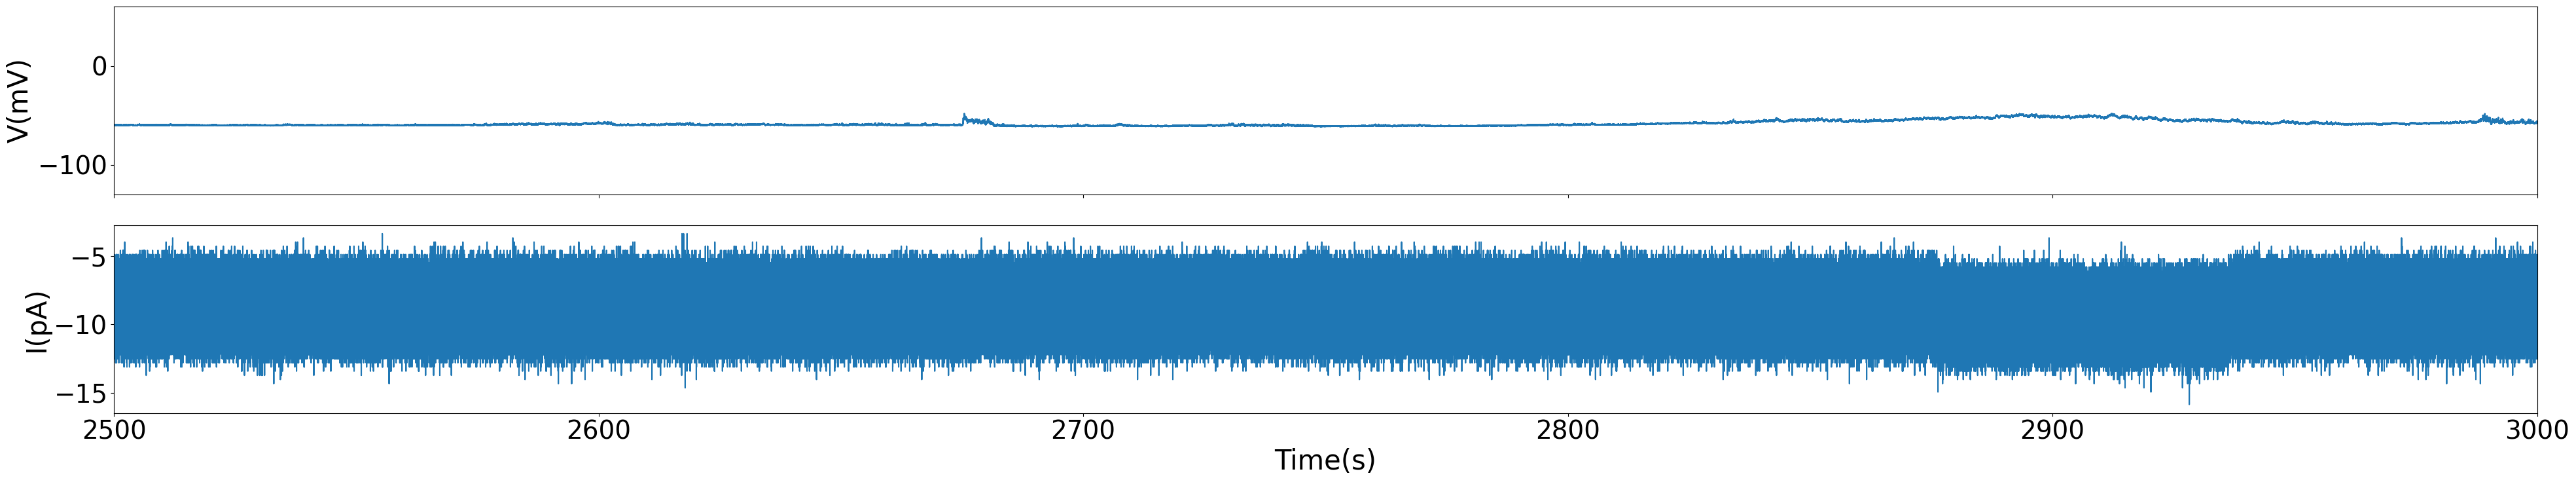

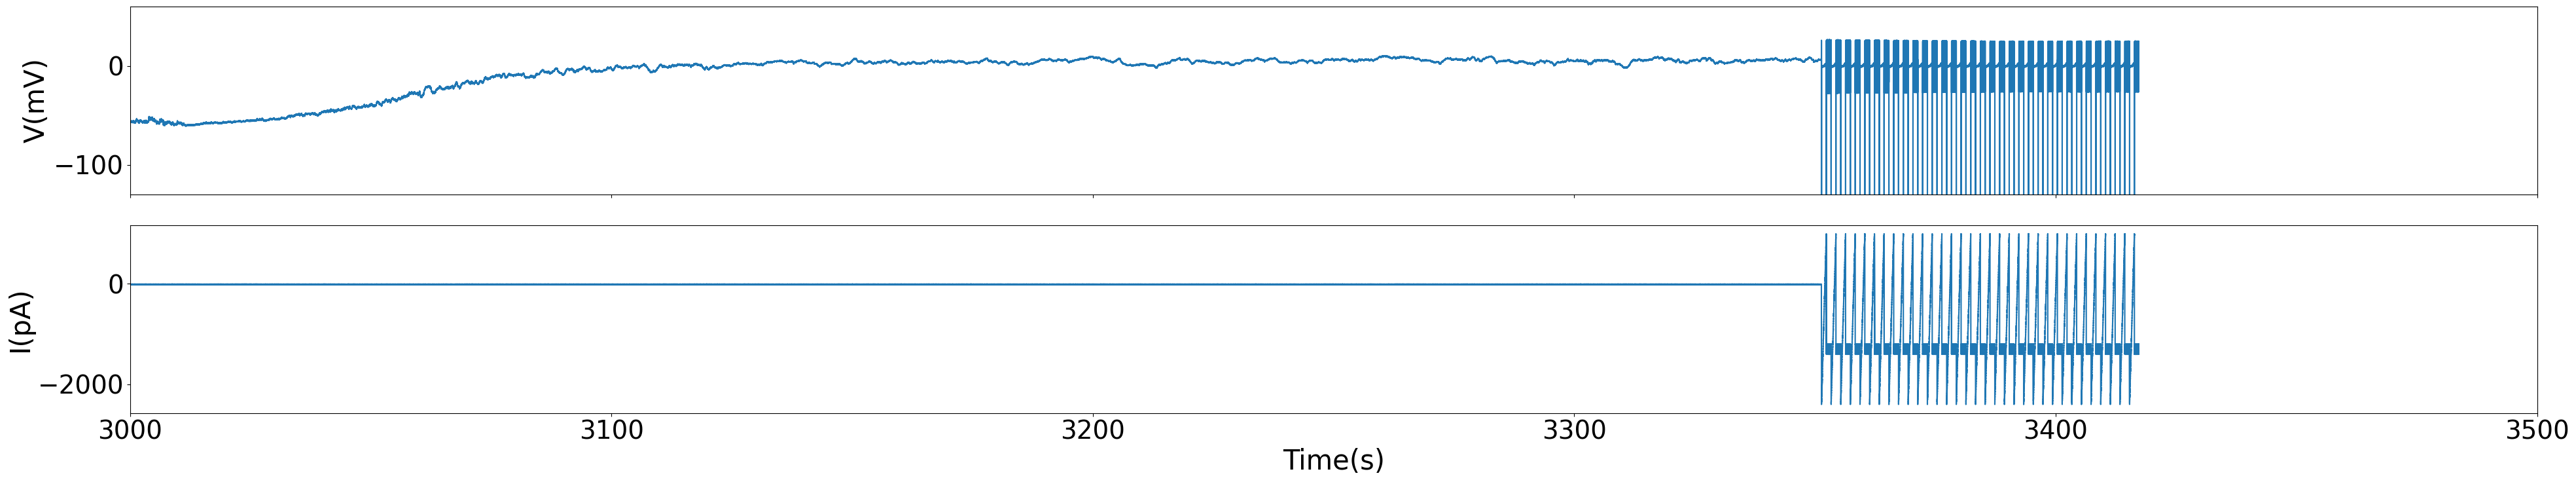

In [7]:
import math
n = math.ceil(times[-1]/500)
SMALL_SIZE = 28
MEDIUM_SIZE = 30
BIGGER_SIZE = 32

for i in range(n):
    fig, axs = plt.subplots(2, 1, sharex=True, figsize = (40,8))
    t_min = i*500
    t_max = (i+1)*500
    axs[0].plot(times[(times>=t_min)&(times<t_max)], V_cc['signal'][(times>=t_min)&(times<t_max)])
    axs[0].set_ylim(-130,60)
    axs[0].set_ylabel('V(mV)')
    #axs[0].set_xlim(times.min(), times.max())
    axs[0].set_xlim(t_min,t_max)
    axs[1].plot(times[(times>=t_min)&(times<t_max)], I_cc['signal'][(times>=t_min)&(times<t_max)])

    axs[1].set_ylabel('I(pA)')
    axs[1].set_xlabel('Time(s)')

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    #plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    fig.tight_layout()
    plt.show()

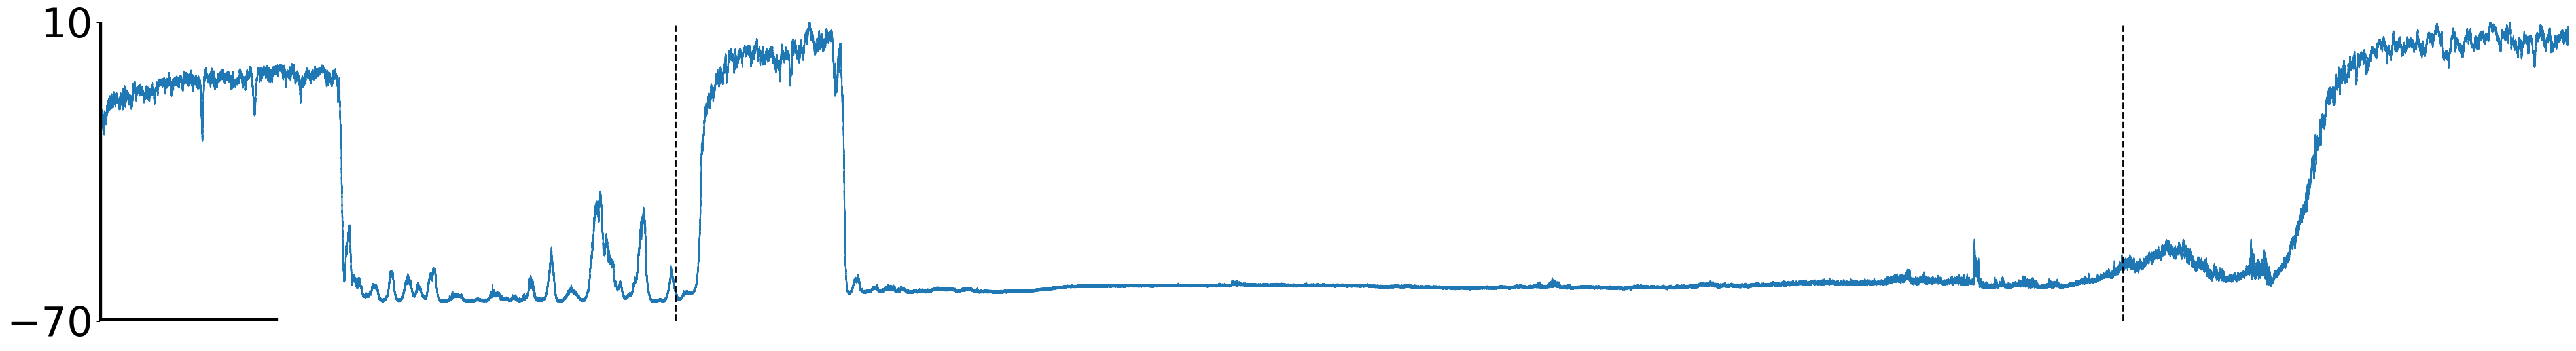

In [12]:
fig, axs = plt.subplots(figsize = (40,6))
t_min = 550
t_max = 3350
t_toxin = 1203
#t_toxin2 = 3042.3
t_washout = 2844.1
y_up = 10
y_bottom = -70
axs.plot(times[(times>=t_min)&(times<t_max)], V_cc['signal'][(times>=t_min)&(times<t_max)])
axs.set_ylim(y_bottom, y_up)
#axs.set_ylabel('V(mV)')
#axs[0].set_xlim(times.min(), times.max())
axs.set_xlim(t_min,t_max)
#axs.set_xlabel('Time(s)')
plot_scalebar(axs, t_min,y_bottom, 200, y_up - y_bottom, thickness = 6, color = 'black')
axs.vlines(x=t_toxin, ymin=y_bottom, ymax=y_up, linewidth=2, color='black', ls = 'dashed')
#axs.vlines(x=t_toxin2, ymin=y_bottom, ymax=y_up, linewidth=2, color='black', ls = 'dashed')
axs.vlines(x=t_washout, ymin=y_bottom, ymax=y_up, linewidth=2, color='black', ls = 'dashed')
#axs.axis('off')
#axs[1].plot(times[(times>=t_min)&(times<t_max)], I_cc['signal'][(times>=t_min)&(times<t_max)])

#axs[1].set_ylabel('I(pA)')
#axs[1].set_xlabel('Time(s)')
#axs.axis('off')
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)

#axs.get_xaxis().set_ticks([])
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.yticks([y_bottom, y_up], fontsize = 45)
plt.xticks([])

fig.tight_layout()
#fig.savefig(r'C:\Users\Firefly\Desktop\patch clamp results\20231129_slip1_cell1_cc_recording.eps', format='eps', dpi = 300)
fig.savefig(r'C:\Users\Firefly\Desktop\patch clamp results\20240131_slip3_cell1_ZD_1mM_washout_cc_recording.png', format='png', dpi = 300)
#fig.savefig(Path(data_dir,'20231129_slip1_cell1_cc_recording.eps'), format='eps', dpi = 300)
fig.savefig(Path(data_dir,'20240131_slip3_cell1_ZD_1mM_washout_cc_recording.png'), format='png', dpi = 300)
plt.show()